# Preamble

This notebook was presented at the COSIMA ocean/sea-ice working group meeting on 21/09/2023.

To run this notebook, you will need to be a member of the following Gadi projects:
- `oi10`
- `ik11`
- `cj50`

In [ ]:
import warnings
warnings.filterwarnings("ignore") # Don't do this outside of this demo

# Introduction to the ACCESS-NRI Intake Catalog

First, a little background material.

# What is Intake?

Intake is a Python package for loading and sharing data

- provides a single interface to access various sources like files, databases and APIs
- at it's core are a set of data loaders (**"drivers"**) for loading different data sources into familiar Python structures (pandas DataFrames, xarray Datasets...)
- some drivers are built into the Intake package
  - CSV
  - JSON
  - ...
- many others are provided by separate **"plugin"** packages
  - Geospatial file formats - via Intake-geopandas
  - PostGres databases - via Intake-postgres
  - NetCDF - via Intake-iris, Intake-xarray, **Intake-ESM**
  - ... (see the list [here](https://intake.readthedocs.io/en/latest/plugin-directory.html))
- also provides systems for cataloging many data sources

# What is Intake-ESM?

Intake-ESM is an Intake **plugin** for *collections* of climate data files (**"`esm_datastore`s"**)

- Let's you search for data that interests you and load that data into xarray Dataset(s)
- Takes care of where the files are and how they fit together into datasets

See [here](https://intake-esm.readthedocs.io/en/stable/) for the documentation

NCI manages Intake-ESM datastores for their CMIP5/6 data collections. They can be used to easily find and load CMIP data as demonstrated below.

In [2]:
import intake

Start a dask LocalCluster to parallelize our work

In [3]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

Open one of the NCI-managed CMIP Intake-ESM datastores

In [4]:
cmip6_datastore = intake.open_esm_datastore(
    "/g/data/dk92/catalog/v2/esm/cmip6-oi10/catalog.json"
)

Search for and load some data

In [5]:
cmip6_datastore_filtered = cmip6_datastore.search(
    experiment_id="historical",
    source_id=["EC-Earth3", "MIROC6", "NorESM2-LM", "NorESM2-MM"],
    variable_id="tos",
    frequency="mon",
    member_id="r1i1p1f1",
)

In [6]:
xarray_combine_by_coords_kwargs = dict(
    compat="override",
    data_vars="minimal", 
    coords="minimal",
)

dataset_dict = cmip6_datastore_filtered.to_dataset_dict(
    progressbar=False,
    xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs
)

In [7]:
dataset_dict

{'f.CMIP.MIROC.MIROC6.historical.r1i1p1f1.mon.ocean.Omon.tos.gn.v20181212': <xarray.Dataset>
 Dimensions:             (time: 1980, bnds: 2, y: 256, x: 360, vertices: 4)
 Coordinates:
   * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12...
     time_bnds           (time, bnds) datetime64[ns] dask.array<chunksize=(1200, 2), meta=np.ndarray>
   * y                   (y) float64 -88.0 -85.75 -85.25 ... 148.6 150.5 152.4
     y_bnds              (y, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
   * x                   (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
     x_bnds              (x, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
     latitude            (y, x) float32 dask.array<chunksize=(256, 360), meta=np.ndarray>
     longitude           (y, x) float32 dask.array<chunksize=(256, 360), meta=np.ndarray>
     vertices_latitude   (y, x, vertices) float32 dask.array<chunksize=(256, 360, 4), meta=np.ndarray>
     ver

# What is the ACCESS-NRI Intake catalog

The ACCESS-NRI Intake catalog is a collection of Intake-ESM datastores for a wide range of climate data products on Gadi (~3 PB):
- COSIMA (ACCESS-OM2) experiments
- ACCESS-ESM1.5 experiments
- ACCESS-CM2 experiments
- CMIP5/6 data
- Whatever else you want to add (within reason)

It provides a search API similar to Intake-ESM to help you find the product(s) that interest you and load their Intake-ESM datastore(s).

See [here](https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html) for the documentation.

In [8]:
catalog = intake.cat.access_nri

In [9]:
catalog

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}","{3hr, 1mon, 3mon, 1day, fx}","{total_ocean_heat, sea_level, strength_m, alvdr_ai_m, evap, total_ocean_runoff, pot_temp, surface_salt, sfc_salt_flux_ice, ty_trans_rho, total_ocean_evap_heat, rhoave, ANGLE, Tsfc_m, vsurf, temp_v..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1day, fx, 1mon}","{vvel, total_ocean_heat, sea_level, strength_m, alvdr_ai_m, evap, vorticity_z, total_ocean_runoff, pot_temp, surface_salt, aice, sfc_salt_flux_ice, ty_trans_rho, temp_xflux_adv_int_z, total_ocean_..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1day, fx, 1mon}","{vvel, total_ocean_heat, sea_level, strocny_m, strength_m, meltt_m, alvdr_ai_m, evap, fsurf_ai_m, total_ocean_runoff, pot_temp, surface_salt, daidtd, aice, sfc_salt_flux_ice, ty_trans_rho, temp_xf..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1day, fx, 1mon}","{vvel, total_ocean_heat, sea_level, strocny_m, strength_m, meltt_m, alvdr_ai_m, evap, fsurf_ai_m, total_ocean_runoff, pot_temp, surface_salt, daidtd, aice, sfc_salt_flux_ice, ty_trans_rho, salt_yf..."
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{seaIce, ocean}","{3hr, 1mon, 6hr, 1day, fx}","{vvel, vvel_h, strocny_m, alvdr_ai_m, evap, vsurf, mld_max, bmf_u, algal_N_m, surface_det, dic, PP_net, kmu, fe_xflux_adv, npp3d, det, dic_int100, radbio_int100, pprod_gross, total_ocean_melt, ali..."
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},"{seaIce, ocean}","{1day, fx, 1mon, 0hr}","{vvel, total_ocean_heat, sea_level, ml_Nit_m, strocny_m, strength_m, meltt_m, alvdr_ai_m, time_bnds, evap, stf03, fN_ai_m, fsurf_ai_m, total_ocean_runoff, pot_temp, surface_salt, daidtd, aice, sfc..."
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1/1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do \nv1.5.0 OMIP2 interannual forcing},"{seaIce, ocean}","{1day, fx, 1mon}","{sea_level, time_bnds, evap, aice, surface_salt, sfc_salt_flux_ice, ty_trans_rho, temp_xflux_adv_int_z, TLON, tx_trans, bmf_u, sfc_hflux_from_runoff, sfc_salt_flux_coupler, mld_max, temp_int_rhodz..."
025deg_jra55_iaf_omip2_cycle1,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{seaIce, ocean}","{1day, 1yr, 1mon, fx}","{neutral_diffusion_temp, aredi, total_ocean_heat, vvel, fswdn_m, flwup_ai_m, sea_level, strocny_m, strength_m, alvdr_ai_m, meltt_m, evap, albice_m, salt_advection, ice_present_m, fsurf_ai_m, salt_..."
025deg_jra55_iaf_omip2_cycle2,{ACCESS-OM2},{Cycle 1/6 of 0.25 degree ACCESS-OM2 physics-only global configuration with JRA55-do v1.4 OMIP2 interannual forcing (1958-2019)},"{seaIce, ocean}","{1day, 1yr, 1mon, fx}","{neutral_diffusion_temp, aredi, total_ocean_heat, vvel, fswdn_m, flwup_ai_m, sea_level, strocny_m, strength_m, alvdr_ai_m, meltt_m, evap, albice_m, salt_advection, ice_present_m, fsurf_ai_m, salt_..."


# Filtering products and data discovery

We can search on the columns in the catalog. For example, below we search for all products that use the model `ACCESS-OM2` and contain variables starting with the letter "w" at daily frequency. The `search` method returns another catalog object with entries that satisfy our search criteria.

In [10]:
catalog_filtered_example = catalog.search(
    model="ACCESS-OM2", 
    frequency="1day", 
    variable="w.*"
)

catalog_filtered_example

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},{ocean},{1day},{wt}
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},{wt}
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4/4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},{1day},{wdet100}
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4/4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 OMIP2 interannual forcing},{ocean},{1day},{wdet100}


# Loading Intake-ESM datastores

There are three ways to open Intake-ESM datastores from the catalog, depening on your use case:

### 1. You know the `name` of the product you want

In this case, you can open the Intake-ESM datastore for that product directly as an attribute or key. For example:

In [11]:
datastore_example = catalog["01deg_jra55v13_ryf9091"]

### 2. You've filtered the catalog for the products you want and there are multiple remaining

In this case, you can open the Intake-ESM datastores for all entries in a catalog using the `to_source_dict` method. For example:

In [12]:
datastore_dict_example = catalog_filtered_example.to_source_dict()

### 3. You've filtered the catalog for the products you want and there's only one remaining 

In this case, you can open the Intake-ESM datastore for the remaining product using the `to_source` method (note you could also use `to_source_dict` which would return a dictionary containing the Intake-ESM datastore, rather than the datastore itself). For example:

In [13]:
datastore_example = catalog.search(name="01deg_jra55v13_ryf9091").to_source()

Note, each Intake-ESM datastore in the catalog has its own `.metadata` attribute that contains additional information about that experiment.

In [14]:
datastore_example.metadata

{'contact': 'Andy Hogg',
 'created': '2020-06-11',
 'description': '0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091  repeat year forcing (May 1990 to Apr 1991)',
 'email': 'andy.hogg@anu.edu.au',
 'experiment_uuid': '79501fdd-80ae-47ef-bb96-425ceed99f1b',
 'keywords': ['tenth', 'cosima', 'access-om2-01', 'jra55-do-v1.3', 'ryf'],
 'license': None,
 'long_description': '0.1 degree ACCESS-OM2 global model configuration under the RYF9091 Repeat Year Forcing strategy outlined by Stewart et al. (2020), https://doi.org/10.1016/j.ocemod.2019.101557. The configuration is based on that described in Kiss et al. (2020), https://doi.org/10.5194/gmd-13-401-2020, but with many improvements. Initial conditions are WOA13v2 potential temperature and practical salinity. Run with JRA55-do v1.3 RYF9091 forcing. Spin up starts from a nominal year of 1 Jan 1900 and runs to 31 Dec 2100.',
 'model': ['ACCESS-OM2'],
 'name': '01deg_jra55v13_ryf9091',
 'nominal_resolution': ['0.1 degr

# Loading datasets

Once you have the Intake-ESM datastores for the product(s) that interest you, you can load datasets as demonstrated above (noting that the CMIP6 schema is not used for all the datastores)

In [15]:
import matplotlib.pyplot as plt

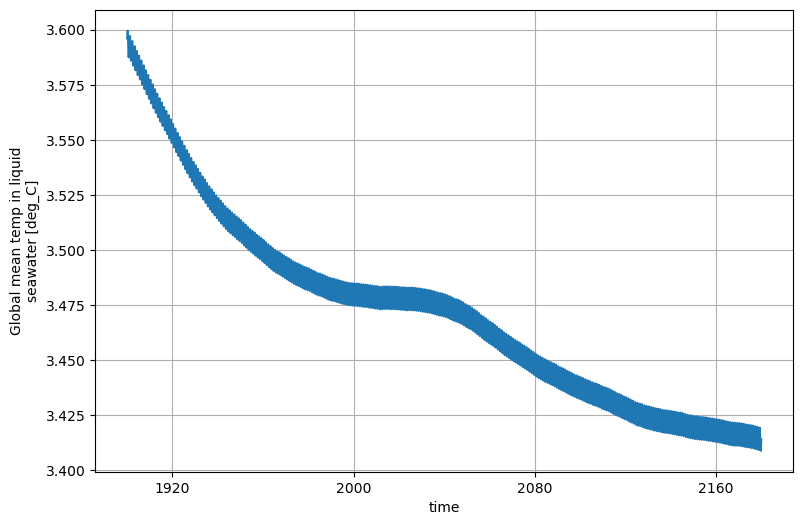

In [16]:
fig, ax = plt.subplots(figsize=(9,6))

dataset = datastore_example.search(variable="temp_global_ave").to_dask()

dataset["temp_global_ave"].plot(ax=ax)

ax.set_title("")
ax.grid()

# A COSIMA-specific, multi-experiment example

Compare all ACCESS-OM2 products with the variable `temp_global_ave` at monthly frequency

In [17]:
catalog_filtered = catalog.search(
    model="ACCESS-OM2",
    frequency="1mon", 
    variable="temp_global_ave"
)

datastore_dict = catalog_filtered.to_source_dict(pass_query=True)

Open all the data into an xarray-datatree. The following maybe looks complicated, but most of the logic is splitting the product name into a base name and cycle number.

In [18]:
import re
from datatree import DataTree, map_over_subtree

In [19]:
dataset_dict = {}
for name, datastore in datastore_dict.items():
    match = re.search("cycle\d*", name)
    if match:
        cycle = name[match.start():]
        name = name[:match.start()-1]
        path = f"{name}/{cycle}"
    else:
        path = name

    ds = datastore.to_dask(
        xarray_open_kwargs=dict(use_cftime=True),
        xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs
    )
    ds.attrs["experiment"] = name
    dataset_dict[path] = ds

dt = DataTree.from_dict(dataset_dict)

With xarray datatree, it's really easy to apply operations over subtrees.

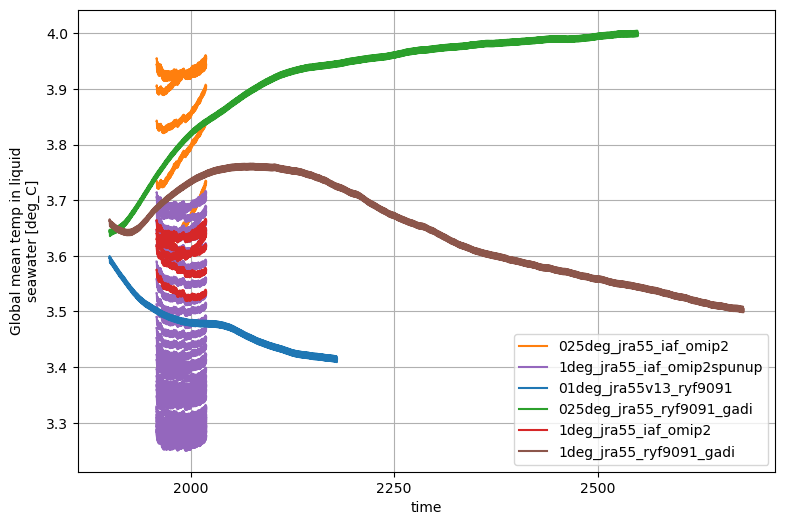

In [20]:
fig, ax = plt.subplots(figsize=(9,6))

colors = {
    "01deg_jra55v13_ryf9091": "C0",
    "025deg_jra55_iaf_omip2": "C1",
    "025deg_jra55_ryf9091_gadi": "C2",
    "1deg_jra55_iaf_omip2": "C3",
    "1deg_jra55_iaf_omip2spunup": "C4",
    "1deg_jra55_ryf9091_gadi": "C5",
}

@map_over_subtree
def plot_global_mean(ds):
    label = ds.attrs["experiment"]
    ds["temp_global_ave"].plot(ax=ax, color=colors[label], label=label) 
    return ds

plot_global_mean(dt)
ax.set_title("")
ax.grid()

# Remove duplicates in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

In [21]:
client.close()